# Why quadrature can be a bad choice for oscillatory integrals

This is a quick example demonstrating how standard quadrature-based approximation of an oscillatory integral can fail at high frequencies.

For this example we will focus on the oscillatory integral:
$$ I(x) = \int_0^1 t^{5/2}\sin(tx) dx,\quad x\to\infty.$$

# Quadrature recap

A standard $N$-point quadrature rule approximation is of the form
$$I(x)\approx Q(x):=\sum_{n=1}^N w_nt_n^{5/3}\sin(t_nx),$$
with weights $(w_n)_{n=1}^N$ and nodes $(t_n)_{n=1}^N$.

Popular quadrature rules include:
* The trapezium rule
* Simpson's rule
* Gaussian quadrature

Just to clarify - **this course is not about quadrature**. This example merely demonstrates a simple case where quadrature becomes impractical, motivating the alternative approach of **asymptotic methods** (which is exactly what this course is about).

If you are interested in the quadrature that we will use in our examples, feel free to read the next couple of sentences. We will often use Julia's [QuadGK](https://juliamath.github.io/QuadGK.jl/latest/) package to approximate the integral to a very high degree of accuracy, so that we have something to check our asymptotic approximations against. Behind the scenes, this uses adaptive [Gauss-Kronrod quadrature](https://en.wikipedia.org/wiki/Gauss–Kronrod_quadrature_formula) which is very efficient for a broad class of integrals. By default, the maximum value of $N$ is $6.7\times10^7$.

In [1]:
using QuadGK #import Gauss-Kronrod library
#define quadrature approximation which depends on x.
function Q(x,rtol=1e-8)
    f(t) = t.^(5/2).*sin.(t*x) #our integand
    t = @elapsed begin # approximate the integral, and time it
        t = I_,err = quadgk(f,0,1,rtol=rtol)
    end
    rel_err = err/abs(I_)
    # return three outputs: 
    # quadrature approximation, relative error estimation, CPU time
    return I_, rel_err, t
end

Q (generic function with 2 methods)

# Testing for large $x$
In the box below, we can experiment with increasingly large values of $x=10,\ldots,10^6$, then measure the time taken and the accuracy of the quadrature rule:

In [4]:
x = 10^5 # chosen 'large' value of x to experiment with

#now print the details:
using Printf
val, err, time = Q(x)
@printf("%e relative error in %e seconds",err,time)

9.999161e-09 relative error in 1.245814e-01 seconds

A key observation is that the CPU time increases with $x$. Let's test this hypothesis by plotting a graph:

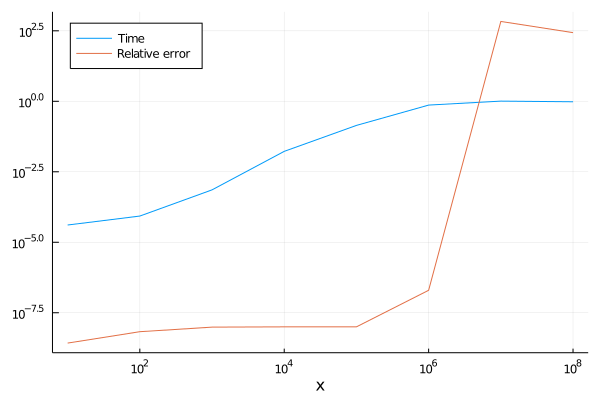

In [7]:
using Plots
num_tests = 8
T = zeros(num_tests)
E = zeros(num_tests)
x_range = 10 .^(1:num_tests)
count = 1
for x = x_range
    T[count] = @elapsed Q(x)
    _,E[count] = Q(x)
    count = count + 1
end
plot(x_range,[T E],
    xaxis=:log,yaxis=:log,legend=:topleft,xlabel="x",
    label = ["Time" "Relative error"])

The time appears to increase linearly with $x$ between $10^2$ and $10^6$, and the relative error remains low. In theory, for oscillatory integrals such as these, one must choose $N=O(x)$ as $x\to\infty$ for quadrature approximations to remain accurate. In practice this means that CPU time will also scale like $O(x)$ as we observe here, which is certainly undesirable for large $x$.

Conversely, for fixed $N$ (number of weights and nodes), we can choose $x$ large enough such that our quadrature rule will be inaccurate. In practice, $N$ is restricted by the computer memory availabe (here its maximum value is about $N=6.7\times10^7$), so for $x$ large enough our quadrature rule will become innacurate. This is what we observe for $x>10^6$.

# Asymptotic approximation
As described in the lecture notes, we can instead approximate $I(x)$ using *repeated integration by parts*, to obtain the following:
$$
I(x) \approx A(x) := \frac{(15 - 4x^2)\cos(x) + 10x\sin(x)}{4 x^3}
$$
Which is increasingly accurate for large $x$.

In [178]:
A(x) = ((15 - 4x^2)*cos(x) + 10x*sin(x))/(4x^3)

A (generic function with 1 method)

Now let's compare this to $Q(x)$ for $x=10^5$, which was the final value before the quadrature rule began to lose accuracy:

In [194]:
x = 1e5
Q_approx,_,Qtime = Q(x)
A_approx=A(x)
Atime = @elapsed A(x) # run it a second time to time it

@printf("Q(x)=%.8e,\t ran in %f secs\n",Q_approx, Qtime)
@printf("A(x)=%.8e,\t ran in %f secs.\n",A_approx, Atime)


Q(x)=9.99361701e-06,	 ran in 0.159652 secs
A(x)=9.99361701e-06,	 ran in 0.000002 secs.


We observe that the asmyptotic approximation $A(x)$ matches our quadrature approximation $Q(x)$ up to eight digits of accuracy, in a fraction of the CPU time!

**Take home message:**

When quadrature fails, asymptotic methods can offer a fast and accurate alternative.